# EPL Prediction Using Machine Learning

![EPL](https://cdn.comparitech.com/wp-content/uploads/2017/08/2017-08-24-13_56_41-newpremierleaguelogo_800x450.jpg-1296%C3%97729-e1503597444647.jpg)

##In this Program I have tried to Predict the Top 6 players who will score more than 8 points next gameweek.

In [0]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
import json
import matplotlib.pyplot as plt

##Taking the Teams from the Table

We are following these steps:
1. First,  We will get the data from the following website - http://www.espnfc.com/barclays-premier-league/23/table
2. We will only take the data we want, and arrange the teams according to the position
3. We are also converting the data into a csv file so it is easy to store



In [0]:
# Downloading and parsing the data into a Python dict

team_dict = {}

url = 'http://www.espnfc.com/barclays-premier-league/23/table'
r  = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser') 
# Note: html5lib deals better with broken html than lxml

for td in soup.findAll('td', { 'class' : 'pos' }):
    rank = int(td.text)
    res = [i.text for i in td.next_siblings if isinstance(i, bs4.element.Tag) and i.text!='\xa0']
    team_name = res[0].strip()
    print team_name, rank
    
    values = []
    for i in res[1:]:
        a = i.replace(u'\xa0', '0')
        values.append(int(a))
    
    team_dict[team_name] = [rank] + values


for i in team_dict:
    remove_val = [1, 8, 14, 20]
    team = team_dict[i]
    shift = 0 
    for j in remove_val:
       
        team.pop(j + shift)
        shift = shift - 1
    
    


df = pd.DataFrame.from_dict(team_dict, orient='index')
cols = ['Pos','P_ov','W_ov','D_ov','L_ov','F_ov','A_ov',
            'W_hm','D_hm','L_hm','F_hm','A_hm', 'W_aw',
            'D_aw','L_aw','F_aw','A_aw','GD','PTS']
df.columns = cols
df = df.sort_values('Pos')
df['team'] = df.index
df = df[['team']+cols]
df


df.to_csv('./fantasyfootballscout.csv', index=False)

Manchester City 1
Manchester United 2
Liverpool 3
Tottenham Hotspur 4
Chelsea 5
Arsenal 6
Burnley 7
Leicester City 8
Everton 9
AFC Bournemouth 10
Watford 11
Brighton & Hove Albion 12
Newcastle United 13
Swansea City 14
Huddersfield Town 15
Crystal Palace 16
West Ham United 17
Southampton 18
Stoke City 19
West Bromwich Albion 20


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  # This is added back by InteractiveShellApp.init_path()


## Taking Information about the Players

Now we follow these steps:

1. We are taking the data from the following json file - https://fantasy.premierleague.com/drf/bootstrap-static
2. Then we are taking the information of the players


In [0]:
#import numpy as np
#import matplotlib.pyplot as plt
#plt.ioff()

url = "https://fantasy.premierleague.com/drf/bootstrap-static"
r  = requests.get(url)
data = json.loads(r.text)
all_players = data['elements']

player_dict = {}
for i in all_players:
    player_dict[i['id']] = i['web_name']

print player_dict

{1: u'Ospina', 2: u'Cech', 3: u'Martinez', 4: u'Koscielny', 5: u'Mertesacker', 6: u'Gabriel', 7: u'Beller\xedn', 8: u'Gibbs', 9: u'Jenkinson', 10: u'Monreal', 11: u'Holding', 12: u'Mustafi', 13: u'Kolasinac', 14: u'S\xe1nchez', 15: u'Walcott', 16: u'\xd6zil', 17: u'Cazorla', 18: u'Ramsey', 19: u'Chamberlain', 20: u'Coquelin', 21: u'Iwobi', 22: u'Elneny', 23: u'Xhaka', 24: u'Wilshere', 25: u'Giroud', 26: u'Welbeck', 27: u'P\xe9rez', 28: u'Lacazette', 29: u'Begovic', 30: u'Boruc', 31: u'Federici', 32: u'Francis', 33: u'Steve Cook', 34: u'Daniels', 35: u'Adam Smith', 36: u'Mings', 37: u'Brad Smith', 38: u'Ak\xe9', 39: u'Arter', 40: u'Pugh', 41: u'Surman', 42: u'Stanislas', 43: u'Gosling', 44: u'Gradel', 45: u'Ibe', 46: u'Lewis Cook', 47: u'Fraser', 48: u'Wilson', 49: u'Afobe', 50: u'Mousset', 51: u'King', 52: u'Defoe', 53: u'M\xe4enp\xe4\xe4', 54: u'Ryan', 55: u'Dunk', 56: u'Duffy', 57: u'H\xfcnemeier', 58: u'Bruno', 59: u'Bong', 60: u'Rosenior', 61: u'Goldson', 62: u'Knockaert', 63: u'St

##Arranging the Players according to their Performance

We follow these steps:

  

1. We are checking player's past performance and how many goals he has scored
2. We are then predicting the Future performance of the player using Naives_Bayes Classifier
3. Then we chose those players who will score 8+ points



![NB](http://www.saedsayad.com/images/Bayes_rule.png)

In [0]:
import sys
from sklearn.naive_bayes import GaussianNB
import numpy as np
from time import time


scorers = []
possible_scorers = {}
count = 0
n= 1
for i in player_dict:
    print i, player_dict[i]

    url = "https://fantasy.premierleague.com/drf/element-summary/" + str(i)
    r  = requests.get(url)
    data = json.loads(r.text)
    # data['fixtures']
    value = data['history']

    # print value
    all_features = []
    labels = []
    a = False;
    for j in value:
#         print i['total_points'],i['kickoff_time_formatted']
        features = [int(j['goals_scored']), int(j['total_points']),int(j['clean_sheets'])]
        all_features.append(features)
        if a:
            if j['total_points']>=8:
                labels.append(1)
            else:
                labels.append(0)
        a = True

    first_test = all_features.pop()
    first_test = all_features.pop()
    first_test = all_features.pop()
    first_test = all_features.pop()
    actual_point = all_features.pop()
    first_test = all_features.pop()

    label_test = labels.pop()
    label_test = labels.pop()
    label_test = labels.pop()
    label_test = labels.pop()
    label_test = labels.pop()
   
    
    
   
    print len(all_features)
    print len(labels)
    print first_test

    features_train = all_features
    labels_train = labels
    
#     #########################################################
#     ### your code goes here ###

    clf = GaussianNB()
    t0 = time()
    clf.fit(features_train, labels_train)
    print "training time:", round(time()-t0, 3), "s"
    
    first_test = np.atleast_2d(first_test)
    res = clf.predict(first_test)
    
    if res[0] == 1:
        possible_scorers[player_dict[i]] = actual_point[1]
        
        
    if res[0] == label_test:
        print True
        count += 1
        if res[0] == 1:
            print i
            scorers.append(player_dict[i])
    
    if n==580:
        break
    n+=1
        

print scorers
print possible_scorers

plot_scorers = scorers
plot_possible_scorers = possible_scorers

1 Ospina
24
24
[0, 0, 0]
training time: 0.002 s
True
2 Cech
24
24
[0, 1, 0]
training time: 0.002 s
True
3 Martinez


/usr/local/lib/python2.7/dist-packages/sklearn/naive_bayes.py:432: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python2.7/dist-packages/sklearn/naive_bayes.py:434: RuntimeWarning: invalid value encountered in divide
  (self.sigma_[i, :]), 1)


24
24
[0, 0, 0]
training time: 0.001 s
True
4 Koscielny
24
24
[0, 1, 0]
training time: 0.002 s
5 Mertesacker
24
24
[0, 0, 0]
training time: 0.002 s
6 Gabriel
24
24
[0, 0, 0]
training time: 0.001 s
True
7 Bellerín
24
24
[0, 0, 0]
training time: 0.002 s
True
8 Gibbs
25
25
[0, 0, 0]
training time: 0.001 s
True
9 Jenkinson
24
24
[0, 0, 0]
training time: 0.001 s
True
10 Monreal
24
24
[1, 8, 0]
training time: 0.001 s
11 Holding
24
24
[0, 0, 0]
training time: 0.001 s
True
12 Mustafi
24
24
[0, 1, 0]
training time: 0.001 s
True
13 Kolasinac
24
24
[0, 0, 0]
training time: 0.002 s
14 Sánchez
24
24
[0, 2, 0]
training time: 0.002 s
True
15 Walcott
25
25
[0, 2, 0]
training time: 0.001 s
True
16 Özil
24
24
[0, 4, 0]
training time: 0.002 s
17 Cazorla
24
24
[0, 0, 0]
training time: 0.001 s
True
18 Ramsey
24
24
[0, 2, 0]
training time: 0.001 s
19 Chamberlain
25
25
[0, 1, 0]
training time: 0.002 s
20 Coquelin
24
24
[0, 0, 0]
training time: 0.001 s
True
21 Iwobi
24
24
[0, 2, 0]
training time: 0.002 s
True

24
24
[0, 2, 0]
training time: 0.001 s
True
81 Taylor
24
24
[0, 2, 0]
training time: 0.001 s
True
82 Arfield
24
24
[0, 1, 0]
training time: 0.002 s
83 Marney
24
24
[0, 0, 0]
training time: 0.002 s
True
84 Gudmundsson
24
24
[0, 2, 0]
training time: 0.001 s
85 Defour
24
24
[0, 0, 0]
training time: 0.001 s
True
86 Hendrick
24
24
[0, 2, 0]
training time: 0.001 s
87 Brady
24
24
[0, 0, 0]
training time: 0.002 s
88 Westwood
24
24
[0, 2, 0]
training time: 0.001 s
True
89 Walters
24
24
[0, 0, 0]
training time: 0.001 s
True
90 Cork
24
24
[0, 2, 0]
training time: 0.001 s
True
91 Vokes
24
24
[0, 3, 0]
training time: 0.002 s
True
92 Gray
25
25
[0, 1, 0]
training time: 0.002 s
True
93 Barnes
24
24
[0, 1, 0]
training time: 0.001 s
True
94 Courtois
24
24
[0, 1, 0]
training time: 0.001 s
True
95 Eduardo
24
24
[0, 0, 0]
training time: 0.002 s
True
96 Caballero
24
24
[0, 0, 0]
training time: 0.002 s
True
97 Azpilicueta
24
24
[0, 1, 0]
training time: 0.002 s
True
98 Cahill
24
24
[0, 1, 0]
training time: 0

/usr/local/lib/python2.7/dist-packages/sklearn/naive_bayes.py:434: RuntimeWarning: divide by zero encountered in divide
  (self.sigma_[i, :]), 1)


24
24
[0, 2, 0]
training time: 0.002 s
112 Chalobah
25
25
[0, 0, 0]
training time: 0.002 s
True
113 Batshuayi
24
24
[0, 0, 0]
training time: 0.002 s
True
114 Costa
24
24
[0, 0, 0]
training time: 0.001 s
True
115 Hennessey
25
25
[0, 5, 0]
training time: 0.002 s
True
116 Speroni
25
25
[0, 0, 0]
training time: 0.002 s
117 Tomkins
25
25
[0, 2, 0]
training time: 0.001 s
True
118 Dann
25
25
[0, 0, 0]
training time: 0.002 s
119 Ward
25
25
[0, 0, 0]
training time: 0.001 s
True
120 Kelly
25
25
[0, 1, 0]
training time: 0.002 s
True
121 Delaney
25
25
[0, 0, 0]
training time: 0.002 s
True
122 Souaré
25
25
[0, 0, 0]
training time: 0.001 s
True
123 Schlupp
25
25
[0, 0, 0]
training time: 0.001 s
True
124 van Aanholt
25
25
[0, 3, 0]
training time: 0.002 s
True
125 Puncheon
25
25
[0, 0, 0]
training time: 0.002 s
True
126 Zaha
25
25
[0, 2, 0]
training time: 0.001 s
True
127 McArthur
25
25
[0, 2, 0]
training time: 0.002 s
True
128 Lee Chung-yong
25
25
[0, 0, 0]
training time: 0.001 s
True
129 Cabaye
25
2

25
25
[0, 0, 0]
training time: 0.002 s
True
180 Scannell
25
25
[0, 0, 0]
training time: 0.001 s
True
181 Kachunga
25
25
[0, 0, 0]
training time: 0.001 s
True
182 Ince
25
25
[0, 1, 0]
training time: 0.001 s
True
183 Palmer
24
24
[0, 0, 0]
training time: 0.002 s
True
184 Williams
25
25
[0, 0, 0]
training time: 0.001 s
True
185 Wells
24
24
[0, 0, 0]
training time: 0.001 s
True
186 Quaner
25
25
[0, 2, 0]
training time: 0.001 s
True
187 Depoitre
25
25
[0, 2, 0]
training time: 0.002 s
188 Mounie
25
25
[0, 0, 0]
training time: 0.002 s
189 Schmeichel
24
24
[0, 1, 0]
training time: 0.002 s
True
190 Hamer
24
24
[0, 0, 0]
training time: 0.002 s
True
191 Morgan
24
24
[0, 0, 0]
training time: 0.001 s
True
192 Fuchs
24
24
[0, 1, 0]
training time: 0.002 s
193 Simpson
24
24
[0, 0, 0]
training time: 0.002 s
True
194 Huth
24
24
[0, 0, 0]
training time: 0.001 s
True
195 Benalouane
24
24
[0, 0, 0]
training time: 0.002 s
True
196 Chilwell
24
24
[0, 1, 0]
training time: 0.002 s
True
197 Wagué
25
25
[0, 0, 0

24
24
[0, 3, 1]
training time: 0.001 s
True
257 Agüero
24
24
[1, 6, 1]
training time: 0.002 s
True
258 Iheanacho
24
24
[0, 1, 0]
training time: 0.002 s
True
259 Jesus
24
24
[0, 0, 0]
training time: 0.002 s
True
260 de Gea
24
24
[0, 2, 0]
training time: 0.001 s
261 Romero
24
24
[0, 0, 0]
training time: 0.002 s
True
262 Joel Pereira
24
24
[0, 0, 0]
training time: 0.001 s
True
263 Smalling
24
24
[0, 1, 0]
training time: 0.001 s
True
263
264 Jones
24
24
[0, -2, 0]
training time: 0.001 s
True
265 Shaw
24
24
[0, 0, 0]
training time: 0.001 s
True
266 Rojo
24
24
[0, 0, 0]
training time: 0.002 s
267 Valencia
24
24
[0, 1, 0]
training time: 0.002 s
268 Darmian
24
24
[0, 0, 0]
training time: 0.001 s
True
269 Fosu-Mensah
25
25
[0, 1, 0]
training time: 0.002 s
270 Blind
24
24
[0, 0, 0]
training time: 0.002 s
True
271 Bailly
24
24
[0, 0, 0]
training time: 0.002 s
True
272 Tuanzebe
24
24
[0, 0, 0]
training time: 0.002 s
True
273 Lindelöf
24
24
[0, 0, 0]
training time: 0.002 s
True
274 Mata
24
24
[0, 1

25
25
[0, 1, 0]
training time: 0.001 s
True
332 Pieters
25
25
[0, 1, 0]
training time: 0.001 s
True
333 Muniesa
25
25
[0, 0, 0]
training time: 0.001 s
True
334 Bardsley
24
24
[0, 2, 0]
training time: 0.001 s
True
335 Johnson
25
25
[0, 0, 0]
training time: 0.001 s
True
336 Tymon
25
25
[0, 0, 0]
training time: 0.001 s
True
337 Allen
25
25
[0, 2, 0]
training time: 0.001 s
338 Adam
25
25
[0, 0, 0]
training time: 0.002 s
True
339 Whelan
25
25
[0, 0, 0]
training time: 0.001 s
True
340 Arnautovic
24
24
[0, 0, 0]
training time: 0.002 s
True
341 Afellay
25
25
[0, 0, 0]
training time: 0.001 s
True
342 Shaqiri
25
25
[1, 8, 0]
training time: 0.002 s
343 Imbula
25
25
[0, 0, 0]
training time: 0.002 s
True
344 Bojan
25
25
[0, 0, 0]
training time: 0.002 s
True
345 Sobhi
25
25
[0, 0, 0]
training time: 0.002 s
True
346 Fletcher
25
25
[0, 0, 0]
training time: 0.001 s
True
347 Crouch
25
25
[0, 2, 0]
training time: 0.002 s
True
348 Diouf
25
25
[0, 1, 0]
training time: 0.001 s
349 Berahino
25
25
[0, 1, 0]
t

25
25
[0, 0, 0]
training time: 0.001 s
404 Janmaat
25
25
[1, 8, 0]
training time: 0.001 s
True
405 Mariappa
25
25
[0, 2, 0]
training time: 0.001 s
True
406 Mason
25
25
[0, 0, 0]
training time: 0.001 s
True
407 Kiko Femenía
25
25
[0, 0, 0]
training time: 0.001 s
True
408 Cleverley
25
25
[0, 0, 0]
training time: 0.001 s
True
409 Capoue
25
25
[0, 2, 0]
training time: 0.001 s
True
410 Behrami
25
25
[0, 0, 0]
training time: 0.002 s
True
411 Berghuis
25
25
[0, 0, 0]
training time: 0.001 s
True
412 Amrabat
25
25
[0, 0, 0]
training time: 0.002 s
True
413 Success
25
25
[0, 0, 0]
training time: 0.001 s
True
414 Doucouré
25
25
[0, 10, 0]
training time: 0.001 s
True
415 Pereyra
25
25
[1, 9, 0]
training time: 0.002 s
True
416 Hughes
25
25
[0, 0, 0]
training time: 0.002 s
True
417 Deeney
25
25
[1, 6, 0]
training time: 0.002 s
True
418 Okaka
25
25
[0, 0, 0]
training time: 0.002 s
True
419 Zárate
25
25
[0, 0, 0]
training time: 0.001 s
True
420 Myhill
25
25
[0, 0, 0]
training time: 0.001 s
True
421 Fos

24
24
[0, 2, 0]
training time: 0.002 s
True
475 Robertson
25
25
[0, 1, 0]
training time: 0.002 s
True
476 Pereira
24
24
[0, 0, 0]
training time: 0.002 s
True
477 Manquillo
24
24
[0, 0, 0]
training time: 0.001 s
True
478 Murphy
24
24
[0, 1, 0]
training time: 0.002 s
True
479 Hart
24
24
[0, 0, 0]
training time: 0.001 s
True
480 Chambers
24
24
[0, 0, 0]
training time: 0.001 s
True
481 Brown
24
24
[0, 0, 0]
training time: 0.002 s
True
482 Riedewald
25
25
[0, 0, 0]
training time: 0.002 s
True
483 Danilo
24
24
[0, 0, 0]
training time: 0.002 s
484 Mendy
24
24
[0, 0, 0]
training time: 0.002 s
True
485 Bartley
24
24
[0, 0, 0]
training time: 0.001 s
True
486 Watson
25
25
[0, 0, 0]
training time: 0.002 s
True
487 Chicharito
24
24
[0, 5, 0]
training time: 0.002 s
True
487
488 Joselu
24
24
[0, 0, 0]
training time: 0.002 s
True
489 Nelson
24
24
[0, 0, 0]
training time: 0.001 s
True
490 Pröpper
24
24
[0, 2, 0]
training time: 0.002 s
True
491 Lokilo
25
25
[0, 0, 0]
training time: 0.002 s
True
492 Fode

22
22
[0, 0, 0]
training time: 0.002 s
True
545 Legzdins
20
20
[0, 0, 0]
training time: 0.001 s
True
546 Maitland-Niles
20
20
[0, 0, 0]
training time: 0.001 s
True
547 Green
20
20
[0, 0, 0]
training time: 0.002 s
True
548 Niasse
20
20
[0, 2, 0]
training time: 0.002 s
549 Ramsdale
20
20
[0, 0, 0]
training time: 0.002 s
True
550 Souttar
20
20
[0, 0, 0]
training time: 0.002 s
True
551 Zinchenko
18
18
[0, 3, 1]
training time: 0.002 s
True
552 Mutch
19
19
[0, 0, 0]
training time: 0.001 s
True
553 Molumby
18
18
[0, 0, 0]
training time: 0.001 s
True
554 Lindegaard
18
18
[0, 0, 0]
training time: 0.002 s
True
555 Henry
18
18
[0, 0, 0]
training time: 0.001 s
True
556 Edwards
18
18
[0, 0, 0]
training time: 0.002 s
True
557 Palmer
18
18
[0, 0, 0]
training time: 0.002 s
True
558 Ampadu
16
16
[0, 0, 0]
training time: 0.002 s
True
559 Macey
16
16
[0, 0, 0]
training time: 0.002 s
True
560 Nketiah
15
15
[0, 0, 0]
training time: 0.002 s
True
561 Rodon
15
15
[0, 0, 0]
training time: 0.002 s
True
562 Ngoy

## Printing those Players who will Perform Well

We follow these steps:


1.   Printing top 6 players who will score 8+ points
2.   Printing a graph to show the predicted points



Smalling
Izquierdo
Sigurdsson
Chicharito
Mkhitaryan
Fernández


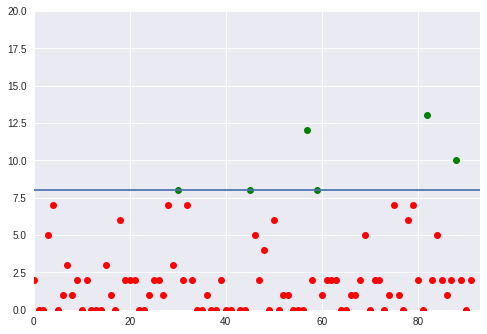

In [0]:
import numpy as np

b = 0
for i in plot_possible_scorers:
    if i in plot_scorers:
        print i
        plt.plot([b],[plot_possible_scorers[i]],'ro', color="g")
    else:
        plt.plot([b],[plot_possible_scorers[i]],'ro', color="r")
    b+=1

plt.axis([0, b+1, 0, 20])
plt.plot([0,b+1], [8, 8])

plt.show()